# MLP

In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns

## Getting Data and MLP Class Definition

In [57]:
df_smote_1000 = pd.read_csv("../Data/df_smote_1000.csv")
df_smote_2500 = pd.read_csv("../Data/df_smote_2500.csv")
df_smote_5000 = pd.read_csv("../Data/df_smote_5000.csv")
df_under_2500 = pd.read_csv("../Data/df_under_2500.csv")

def preprocess(df):
    # using label encoder
    le = LabelEncoder()
    df['Label_encoded'] = le.fit_transform(df['Label'])

    # separating X and y
    X = df.drop(columns=['Label', 'Label_encoded'])
    y = df['Label_encoded']

    # using standard scaler for normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
    )

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    return train_ds, test_ds, train_loader, test_loader, le
    

In [58]:
df_smote_1000_train, df_smote_1000_test, df_smote_1000_train_loader, df_smote_1000_test_loader, df_smote_1000_le = preprocess(df_smote_1000)
df_smote_2500_train, df_smote_2500_test, df_smote_2500_train_loader, df_smote_2500_test_loader, df_smote_2500_le = preprocess(df_smote_2500)
df_smote_5000_train, df_smote_5000_test, df_smote_5000_train_loader, df_smote_5000_test_loader, df_smote_5000_le = preprocess(df_smote_5000)
df_under_2500_train, df_under_2500_test, df_under_2500_train_loader, df_under_2500_test_loader, df_under_2500_le = preprocess(df_under_2500)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, output_dim)

        # Projection layer for residual connection (256 → 128)
        self.res_proj = nn.Linear(256, 128)

        self.dropout = dropout

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        residual = x  # Save for residual connection
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.res_proj(residual) + x  # Project and add residual
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.leaky_relu(self.bn4(self.fc4(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.fc5(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def train_model(model, train_loader, num_epochs=200, lr=0.01, step_size=40, gamma=0.5, device='cpu'):
    '''
    num_epochs: Number of epochs to train the model
    lr: Learning rate

    #learning rate scheduler
    step_size: Number of epochs to wait before reducing the learning rate
    gamma: Factor by which the learning rate is reduced
    '''
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        loss_history.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    # plotting
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, label_encoder, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    # full classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # global evaluation metrics
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)

    print(f"\nOverall Metrics:")
    print(f"Accuracy:       {acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")

    # confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Training and Evaluating SMOTE 1000 model

Epoch 10/250, Loss: 588.7357
Epoch 20/250, Loss: 570.5074
Epoch 30/250, Loss: 556.0414
Epoch 40/250, Loss: 546.7068
Epoch 50/250, Loss: 534.5371
Epoch 60/250, Loss: 533.9530
Epoch 70/250, Loss: 529.8263
Epoch 80/250, Loss: 527.6667
Epoch 90/250, Loss: 520.6271
Epoch 100/250, Loss: 517.1225
Epoch 110/250, Loss: 514.3850
Epoch 120/250, Loss: 516.4641
Epoch 130/250, Loss: 510.5691
Epoch 140/250, Loss: 508.0405
Epoch 150/250, Loss: 507.7935
Epoch 160/250, Loss: 506.3340
Epoch 170/250, Loss: 502.4760
Epoch 180/250, Loss: 501.3846
Epoch 190/250, Loss: 501.5993
Epoch 200/250, Loss: 501.2587
Epoch 210/250, Loss: 498.8261
Epoch 220/250, Loss: 496.5348
Epoch 230/250, Loss: 496.6990
Epoch 240/250, Loss: 496.4156
Epoch 250/250, Loss: 491.8230


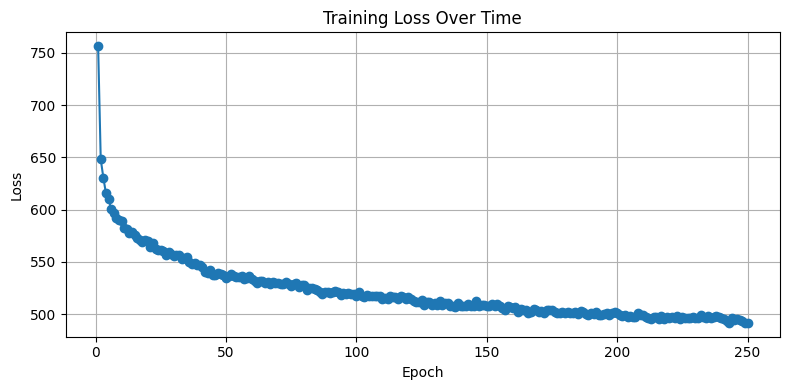

In [ ]:
# df_smote_1000
input_dim = df_smote_1000_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_1000_train.tensors[1]))
model_1000 = MLP(input_dim, output_dim)

# training
model_1000 = train_model(model_1000, df_smote_1000_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)


Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.39      0.14      0.21       200
                 BENIGN       0.25      0.70      0.37       200
       BROWSERHIJACKING       0.46      0.42      0.44       200
       COMMANDINJECTION       0.78      0.25      0.38       200
 DDOS-ACK_FRAGMENTATION       1.00      0.98      0.99       200
        DDOS-HTTP_FLOOD       0.96      0.69      0.81       200
        DDOS-ICMP_FLOOD       1.00      0.99      1.00       200
DDOS-ICMP_FRAGMENTATION       0.99      0.99      0.99       200
      DDOS-PSHACK_FLOOD       1.00      0.98      0.99       200
       DDOS-RSTFINFLOOD       1.00      0.99      0.99       200
         DDOS-SLOWLORIS       0.80      0.99      0.89       200
DDOS-SYNONYMOUSIP_FLOOD       0.37      0.99      0.54       200
         DDOS-SYN_FLOOD       1.00      0.01      0.01       200
         DDOS-TCP_FLOOD       0.50      0.99      0.67       200


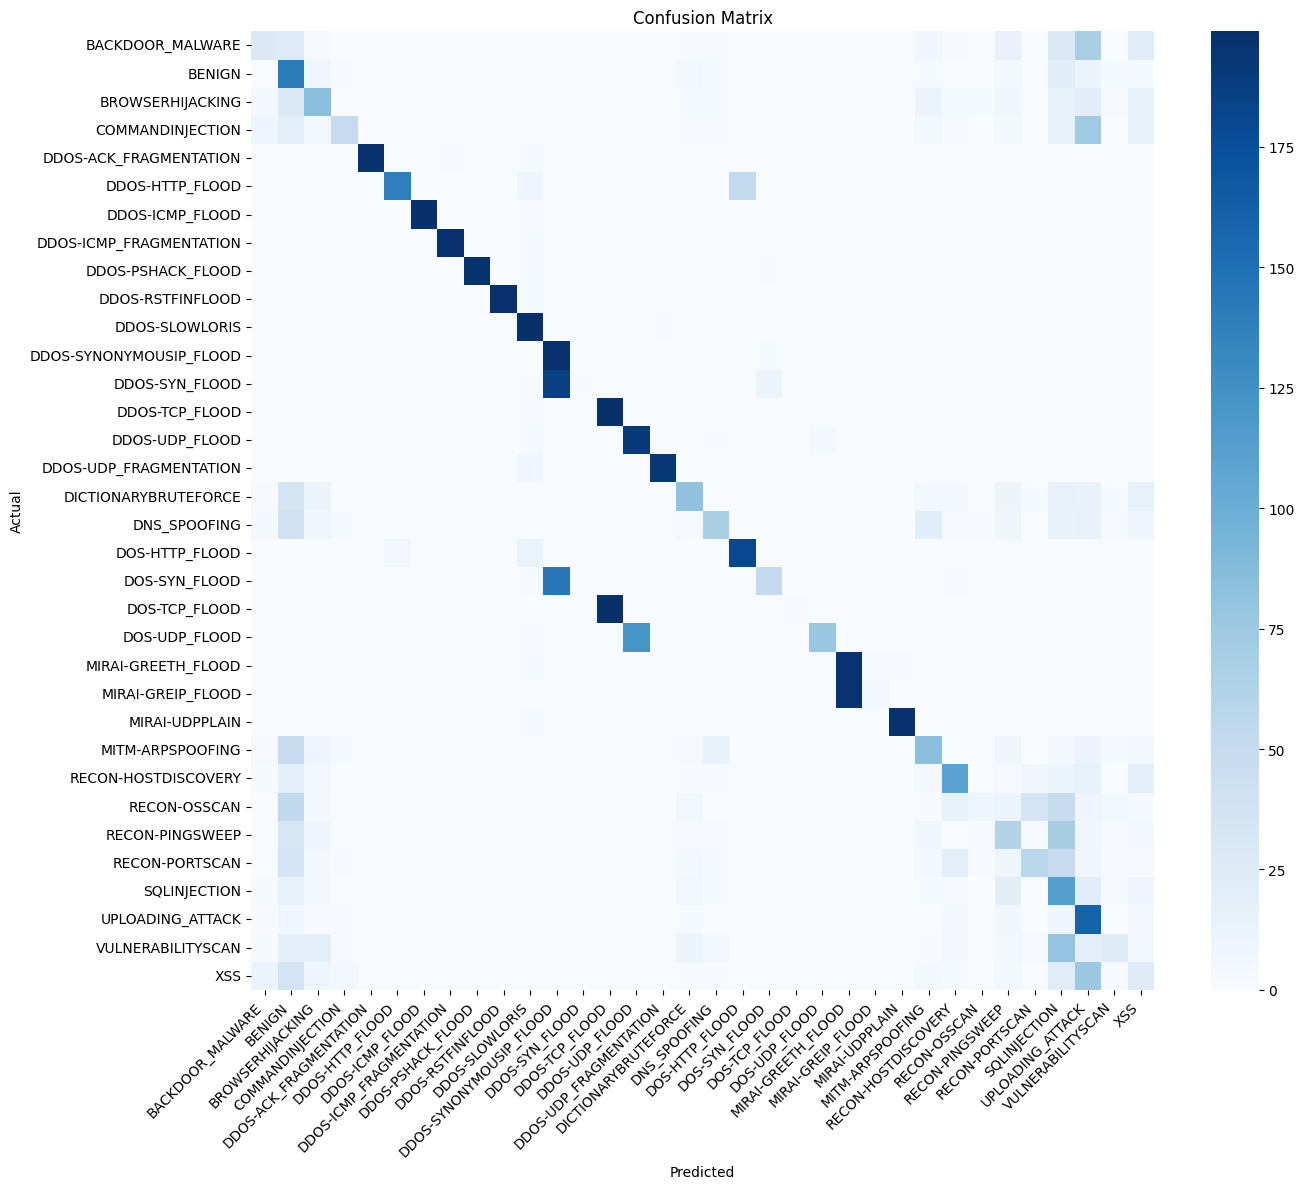

In [63]:
evaluate_model(model_1000, df_smote_1000_test_loader, df_smote_1000_le)

## Training and Evaluating SMOTE 2500 model

Epoch 10/250, Loss: 1410.1935
Epoch 20/250, Loss: 1366.2155
Epoch 30/250, Loss: 1346.5892
Epoch 40/250, Loss: 1329.7434
Epoch 50/250, Loss: 1307.5201
Epoch 60/250, Loss: 1296.5215
Epoch 70/250, Loss: 1295.8174
Epoch 80/250, Loss: 1287.5409
Epoch 90/250, Loss: 1272.2180
Epoch 100/250, Loss: 1268.8188
Epoch 110/250, Loss: 1265.5462
Epoch 120/250, Loss: 1262.2366
Epoch 130/250, Loss: 1248.8901
Epoch 140/250, Loss: 1252.5975
Epoch 150/250, Loss: 1248.4030
Epoch 160/250, Loss: 1245.6431
Epoch 170/250, Loss: 1240.5164
Epoch 180/250, Loss: 1238.3426
Epoch 190/250, Loss: 1234.1068
Epoch 200/250, Loss: 1232.5468
Epoch 210/250, Loss: 1229.2915
Epoch 220/250, Loss: 1230.4544
Epoch 230/250, Loss: 1227.7106
Epoch 240/250, Loss: 1225.5098
Epoch 250/250, Loss: 1221.7855


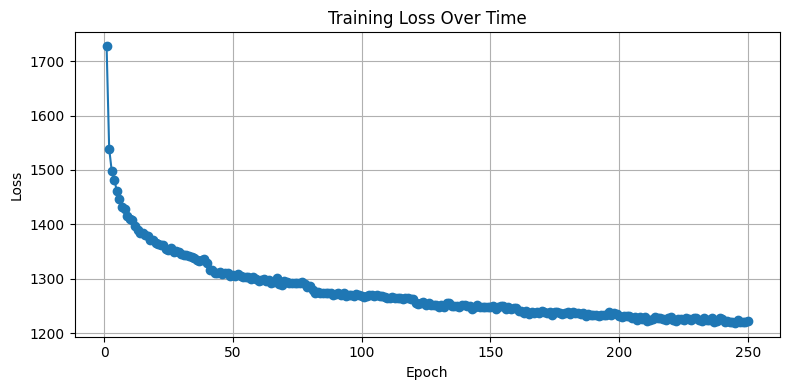

In [ ]:
input_dim = df_smote_2500_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_2500_train.tensors[1]))
model_2500 = MLP(input_dim, output_dim)

# training
model_2500 = train_model(model_2500, df_smote_2500_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)



Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.32      0.18      0.23       500
                 BENIGN       0.33      0.55      0.41       500
       BROWSERHIJACKING       0.34      0.55      0.42       500
       COMMANDINJECTION       0.76      0.28      0.41       500
 DDOS-ACK_FRAGMENTATION       1.00      0.99      0.99       500
        DDOS-HTTP_FLOOD       0.92      0.76      0.83       500
        DDOS-ICMP_FLOOD       1.00      0.99      1.00       500
DDOS-ICMP_FRAGMENTATION       1.00      0.99      0.99       500
      DDOS-PSHACK_FLOOD       1.00      0.99      1.00       500
       DDOS-RSTFINFLOOD       1.00      1.00      1.00       500
         DDOS-SLOWLORIS       0.85      0.99      0.91       500
DDOS-SYNONYMOUSIP_FLOOD       0.38      0.99      0.55       500
         DDOS-SYN_FLOOD       1.00      0.00      0.01       500
         DDOS-TCP_FLOOD       0.54      0.68      0.61       500


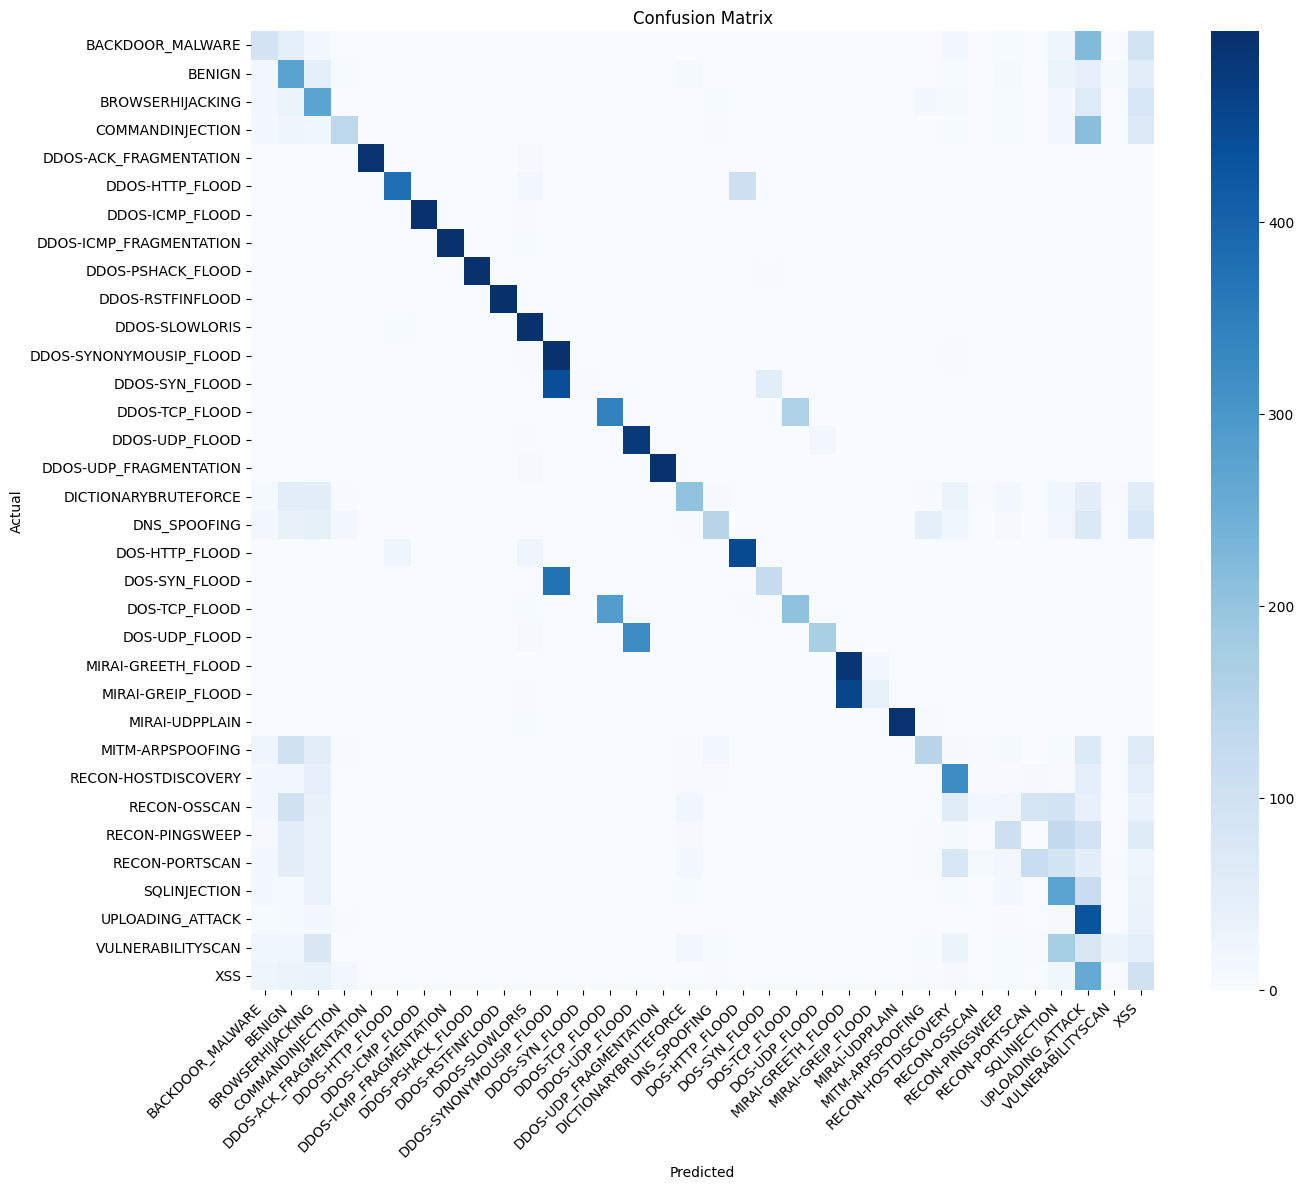

In [64]:
evaluate_model(model_2500, df_smote_2500_test_loader, df_smote_2500_le)

## Training and Evaluating SMOTE 5000 model

Epoch 10/250, Loss: 2738.7281
Epoch 20/250, Loss: 2671.5847
Epoch 30/250, Loss: 2644.4216
Epoch 40/250, Loss: 2612.7368
Epoch 50/250, Loss: 2565.3982
Epoch 60/250, Loss: 2549.3045
Epoch 70/250, Loss: 2541.5438
Epoch 80/250, Loss: 2534.6338
Epoch 90/250, Loss: 2502.3035
Epoch 100/250, Loss: 2499.8897
Epoch 110/250, Loss: 2494.7603
Epoch 120/250, Loss: 2484.9453
Epoch 130/250, Loss: 2467.1126
Epoch 140/250, Loss: 2464.8830
Epoch 150/250, Loss: 2458.1472
Epoch 160/250, Loss: 2453.8083
Epoch 170/250, Loss: 2436.4348
Epoch 180/250, Loss: 2434.4772
Epoch 190/250, Loss: 2430.8602
Epoch 200/250, Loss: 2428.7217
Epoch 210/250, Loss: 2417.3404
Epoch 220/250, Loss: 2415.3238
Epoch 230/250, Loss: 2415.5910
Epoch 240/250, Loss: 2413.8743
Epoch 250/250, Loss: 2403.2132


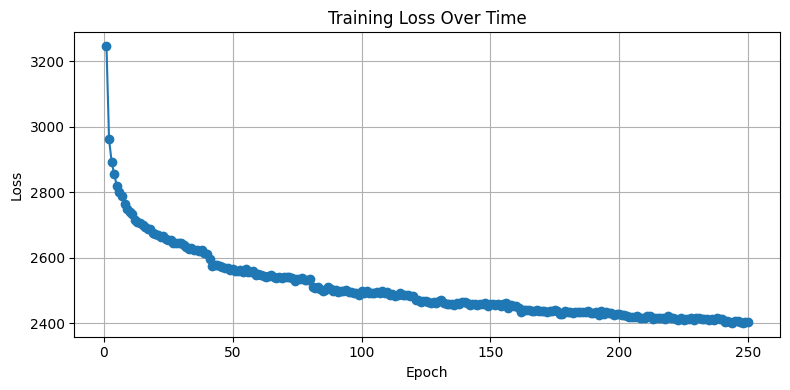

In [34]:
input_dim = df_smote_5000_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_5000_train.tensors[1]))
model_5000 = MLP(input_dim, output_dim)

# training
model_5000 = train_model(model_5000, df_smote_5000_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)



Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.30      0.28      0.29      1000
                 BENIGN       0.31      0.59      0.41      1000
       BROWSERHIJACKING       0.43      0.55      0.49      1000
       COMMANDINJECTION       0.86      0.25      0.38      1000
 DDOS-ACK_FRAGMENTATION       1.00      0.98      0.99      1000
        DDOS-HTTP_FLOOD       0.93      0.74      0.82      1000
        DDOS-ICMP_FLOOD       1.00      1.00      1.00      1000
DDOS-ICMP_FRAGMENTATION       1.00      0.98      0.99      1000
      DDOS-PSHACK_FLOOD       1.00      1.00      1.00      1000
       DDOS-RSTFINFLOOD       1.00      1.00      1.00      1000
         DDOS-SLOWLORIS       0.87      0.99      0.93      1000
DDOS-SYNONYMOUSIP_FLOOD       0.38      1.00      0.55      1000
         DDOS-SYN_FLOOD       0.00      0.00      0.00      1000
         DDOS-TCP_FLOOD       0.00      0.00      0.00      1000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

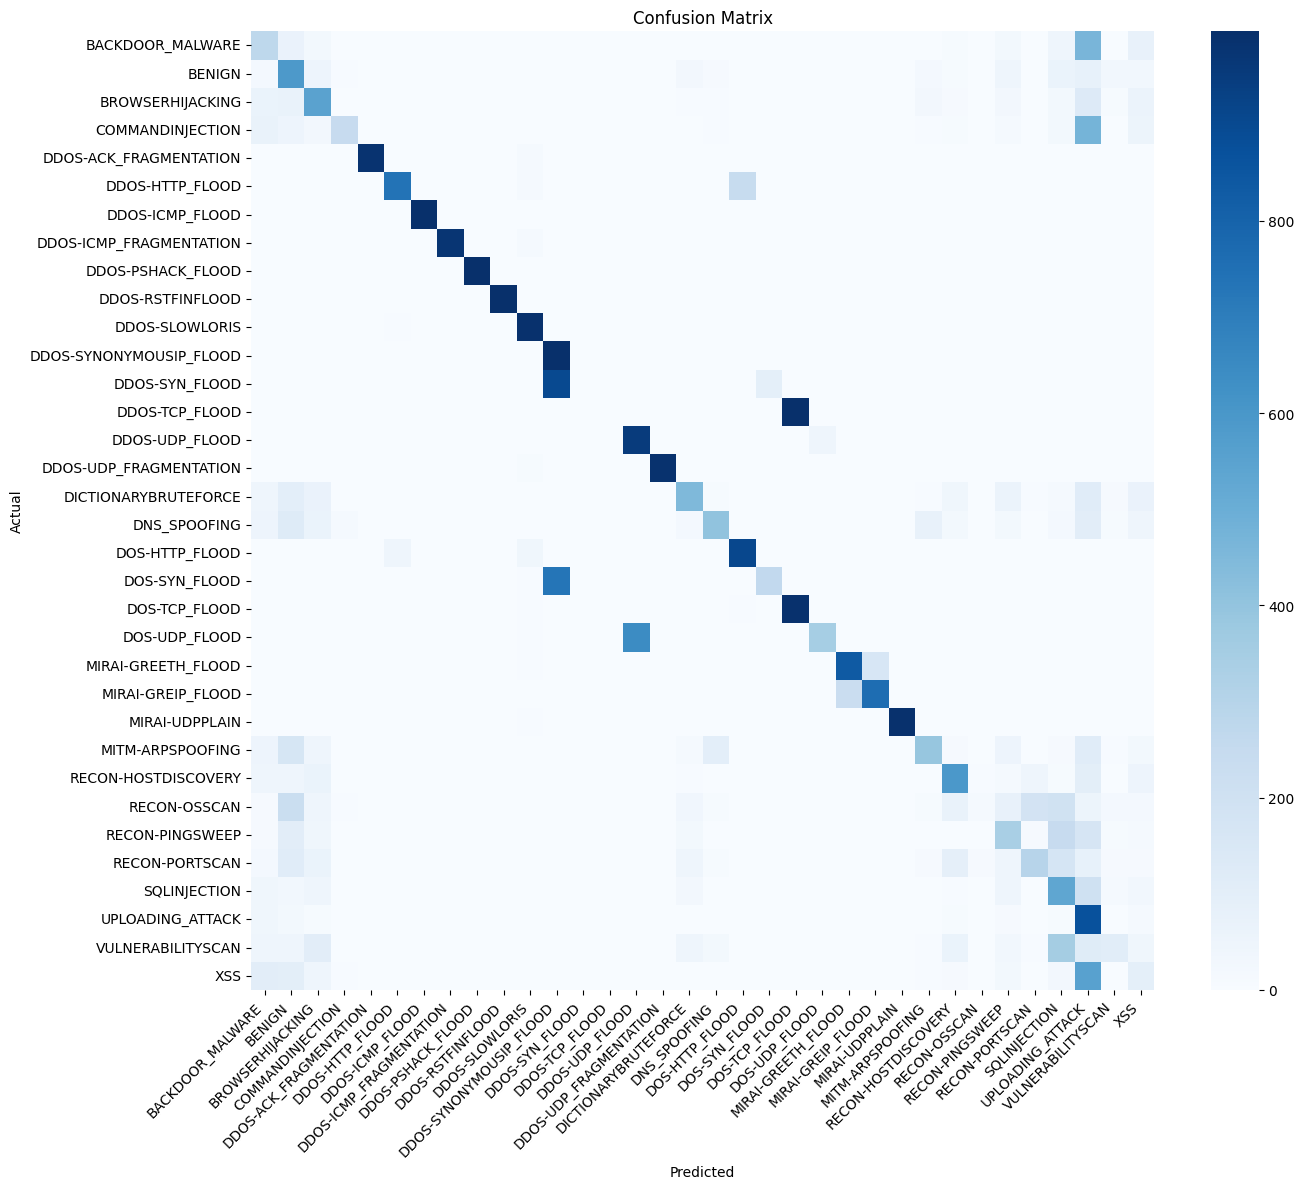

In [65]:
evaluate_model(model_5000, df_smote_5000_test_loader, df_smote_5000_le)

We got SMOTE_1000 accuracy to be 0.68.   
We got SMOTE_2500 accuracy to be 0.67.  

A little disappointed with these results and a little surprised that SMOTE_1000 did better than SMOTE_2500. Ill try using PCA to reduce the feature space.


## Training and Evaluating under 2500 model (no smote, just undersampling -> serves as a control)

Epoch 10/250, Loss: 980.3918
Epoch 20/250, Loss: 945.4922
Epoch 30/250, Loss: 928.9645
Epoch 40/250, Loss: 918.5046
Epoch 50/250, Loss: 895.2349
Epoch 60/250, Loss: 893.1863
Epoch 70/250, Loss: 893.7219
Epoch 80/250, Loss: 888.8237
Epoch 90/250, Loss: 875.7634
Epoch 100/250, Loss: 870.5412
Epoch 110/250, Loss: 874.6863
Epoch 120/250, Loss: 865.9587
Epoch 130/250, Loss: 860.0252
Epoch 140/250, Loss: 859.4792
Epoch 150/250, Loss: 855.2619
Epoch 160/250, Loss: 854.2805
Epoch 170/250, Loss: 847.5660
Epoch 180/250, Loss: 848.1529
Epoch 190/250, Loss: 847.2064
Epoch 200/250, Loss: 848.0768
Epoch 210/250, Loss: 838.1884
Epoch 220/250, Loss: 839.6039
Epoch 230/250, Loss: 840.9851
Epoch 240/250, Loss: 837.5183
Epoch 250/250, Loss: 835.7898


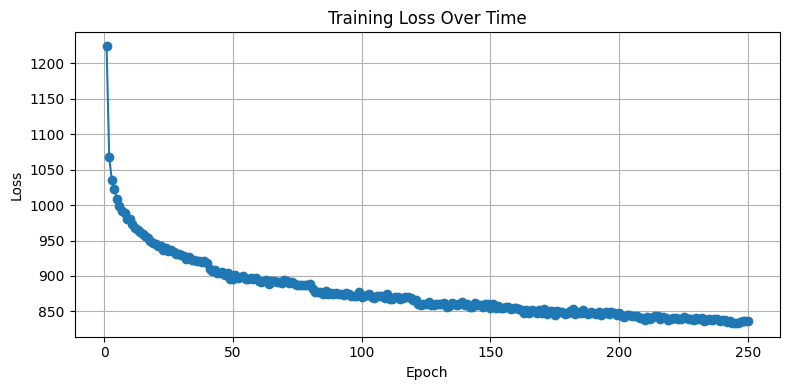

In [59]:
input_dim = df_smote_2500_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_2500_train.tensors[1]))
model_under_2500 = MLP(input_dim, output_dim)

# training
model_under_2500 = train_model(model_under_2500, df_under_2500_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)



Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.00      0.00      0.00        97
                 BENIGN       0.30      0.80      0.44       500
       BROWSERHIJACKING       0.67      0.13      0.22       184
       COMMANDINJECTION       0.46      0.31      0.37       162
 DDOS-ACK_FRAGMENTATION       1.00      0.98      0.99       500
        DDOS-HTTP_FLOOD       0.95      0.69      0.80       500
        DDOS-ICMP_FLOOD       1.00      0.99      0.99       500
DDOS-ICMP_FRAGMENTATION       1.00      0.98      0.99       500
      DDOS-PSHACK_FLOOD       1.00      0.99      0.99       500
       DDOS-RSTFINFLOOD       1.00      1.00      1.00       500
         DDOS-SLOWLORIS       0.83      1.00      0.91       500
DDOS-SYNONYMOUSIP_FLOOD       0.37      1.00      0.54       500
         DDOS-SYN_FLOOD       0.00      0.00      0.00       500
         DDOS-TCP_FLOOD       0.64      0.38      0.48       500


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

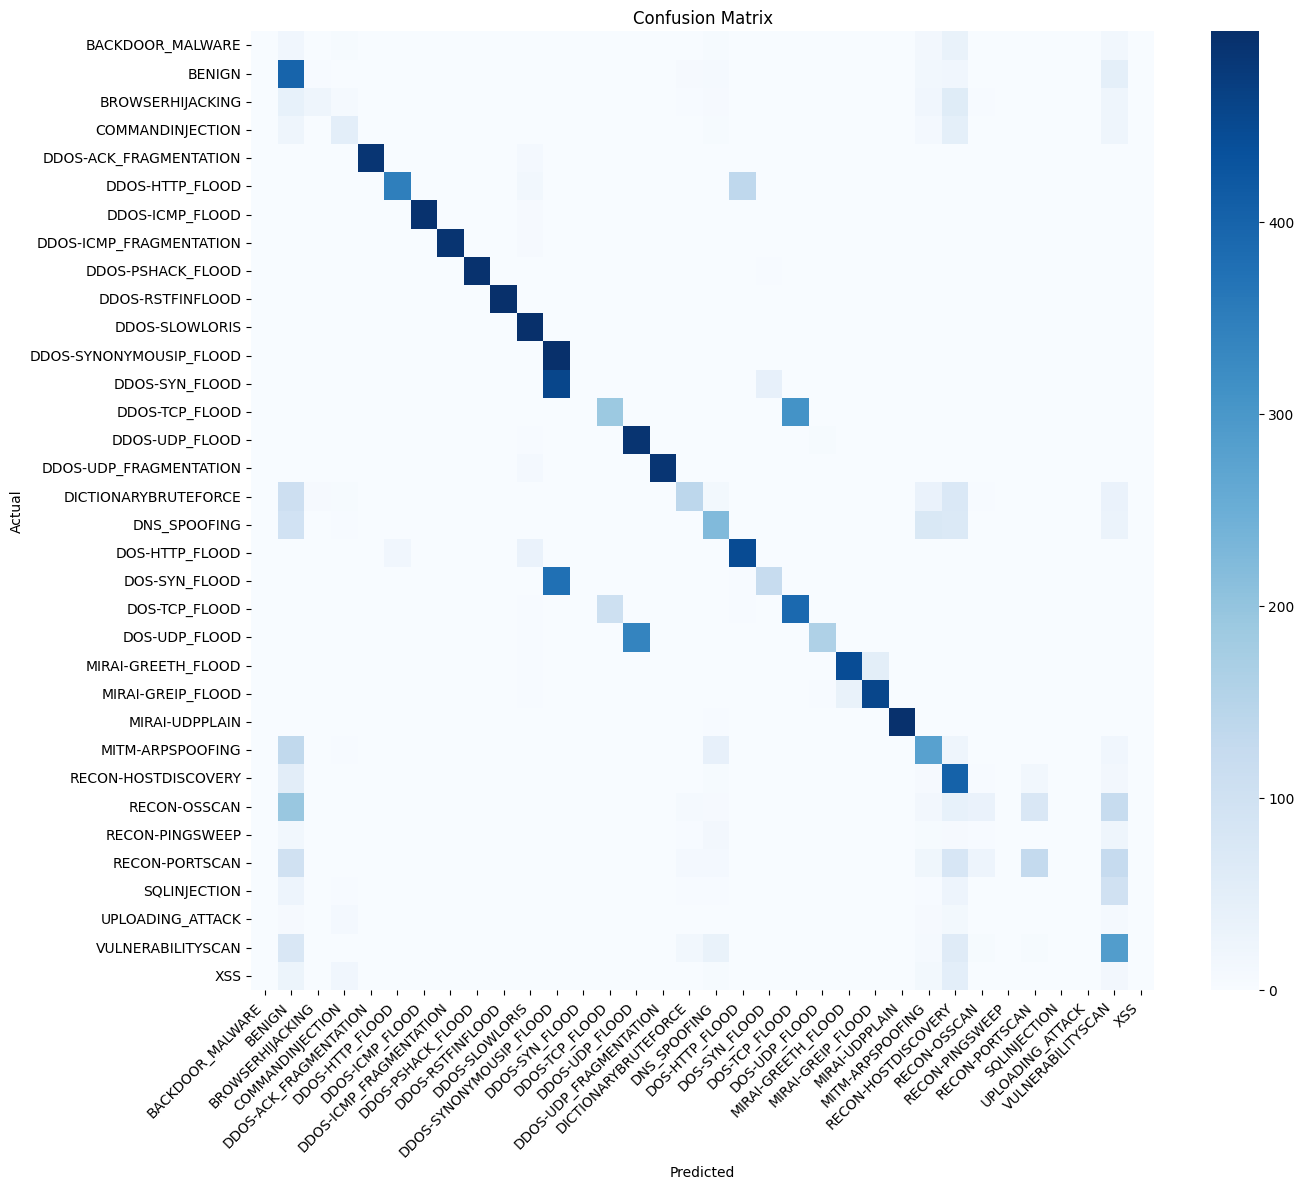

In [66]:
evaluate_model(model_under_2500, df_under_2500_test_loader, df_under_2500_le)

## Training and Evaluating SMOTE 1000 model with PCA of 30 components

In [53]:
from sklearn.decomposition import PCA

def preprocess_with_pca(df, scale=True, n_components=None):
    le = LabelEncoder()
    df['Label_encoded'] = le.fit_transform(df['Label'])

    X = df.drop(columns=['Label', 'Label_encoded'])
    y = df['Label_encoded']

    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = X.values

    if n_components is None:
        raise ValueError("n_components must be specified when use_pca=True")
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
    )

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    return train_ds, test_ds, train_loader, test_loader, le

In [54]:
df_smote_1000_train_pca_30, df_smote_1000_test_pca_30, df_smote_1000_train_loader_pca_30, df_smote_1000_test_loader_pca_30, df_smote_1000_pca_30_le = preprocess_with_pca(df_smote_1000, n_components=30)

Epoch 10/250, Loss: 587.4280
Epoch 20/250, Loss: 568.4146
Epoch 30/250, Loss: 559.7994
Epoch 40/250, Loss: 550.2990
Epoch 50/250, Loss: 540.9989
Epoch 60/250, Loss: 536.7640
Epoch 70/250, Loss: 533.5074
Epoch 80/250, Loss: 531.0140
Epoch 90/250, Loss: 525.0146
Epoch 100/250, Loss: 522.0939
Epoch 110/250, Loss: 521.0713
Epoch 120/250, Loss: 517.2410
Epoch 130/250, Loss: 514.1827
Epoch 140/250, Loss: 514.6815
Epoch 150/250, Loss: 513.5455
Epoch 160/250, Loss: 511.6435
Epoch 170/250, Loss: 510.5915
Epoch 180/250, Loss: 505.2339
Epoch 190/250, Loss: 505.7525
Epoch 200/250, Loss: 504.8264
Epoch 210/250, Loss: 500.7768
Epoch 220/250, Loss: 503.0398
Epoch 230/250, Loss: 500.7540
Epoch 240/250, Loss: 503.6934
Epoch 250/250, Loss: 498.8963


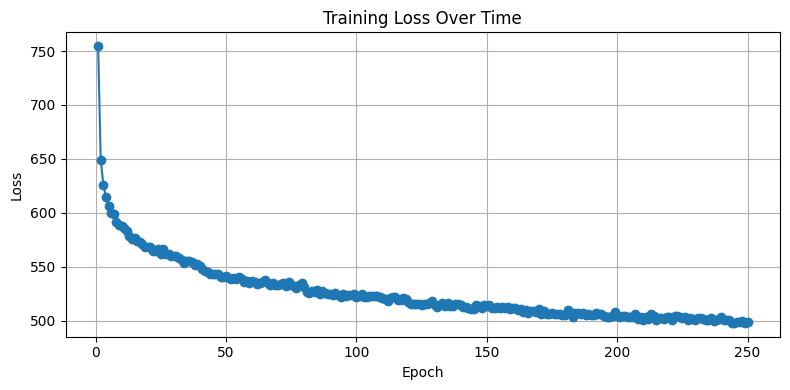

In [55]:
# df_smote_1000
input_dim = df_smote_1000_train_pca_30.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_1000_train_pca_30.tensors[1]))
model_1000_pca_30 = MLP(input_dim, output_dim)

# training
model_1000_pca_30 = train_model(model_1000_pca_30, df_smote_1000_train_loader_pca_30, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)


Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.31      0.17      0.22       200
                 BENIGN       0.28      0.66      0.39       200
       BROWSERHIJACKING       0.45      0.44      0.45       200
       COMMANDINJECTION       0.78      0.23      0.36       200
 DDOS-ACK_FRAGMENTATION       1.00      0.99      0.99       200
        DDOS-HTTP_FLOOD       0.97      0.69      0.80       200
        DDOS-ICMP_FLOOD       1.00      0.99      1.00       200
DDOS-ICMP_FRAGMENTATION       1.00      0.99      0.99       200
      DDOS-PSHACK_FLOOD       1.00      0.98      0.99       200
       DDOS-RSTFINFLOOD       1.00      0.99      0.99       200
         DDOS-SLOWLORIS       0.82      0.99      0.90       200
DDOS-SYNONYMOUSIP_FLOOD       0.38      0.90      0.54       200
         DDOS-SYN_FLOOD       0.39      0.15      0.22       200
         DDOS-TCP_FLOOD       0.00      0.00      0.00       200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

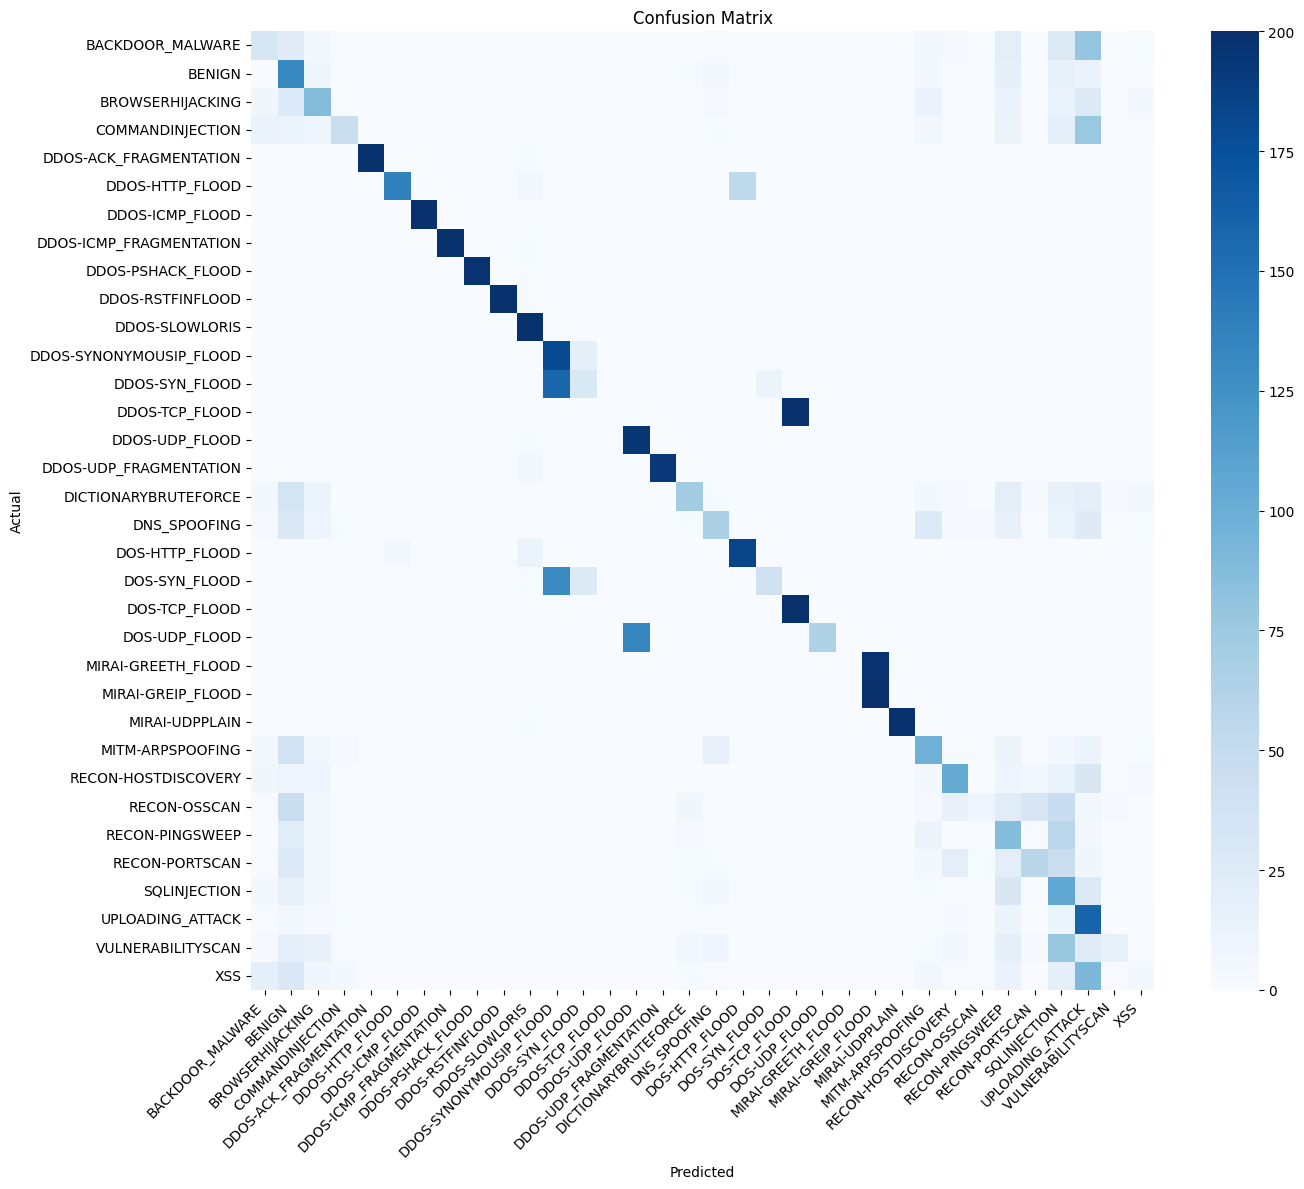

In [67]:
evaluate_model(model_1000_pca_30, df_smote_1000_test_loader_pca_30, df_smote_1000_pca_30_le)

Well, I guess this didnt matter too much either. Seems like XGBOOST might be the best for these classification tasks!.

# Saving the Models (so we dont have to retrain to do further testing)

In [61]:
torch.save(model_1000_pca_30.state_dict(), "model_1000_pca_30.pth")
torch.save(model_1000.state_dict(), "model_1000.pth")
torch.save(model_2500.state_dict(), "model_2500.pth")
torch.save(model_5000.state_dict(), "model_5000.pth")
torch.save(model_under_2500.state_dict(), "model_under_2500.pth")

In [ ]:
# how to reload the mdoels from the .pth files

# model = MLP(input_dim=?, output_dim=?)
# model.load_state_dict(torch.load("model_1000_pca_30.pth"))

## Results

#### SMOTE 1000 Model  
Overall Metrics:  
Accuracy:       0.5756  
Macro F1-score: 0.5394  
Weighted F1-score: 0.5394  
  
#### SMOTE 2500 Model  
Overall Metrics:  
Accuracy:       0.5764  
Macro F1-score: 0.5501  
Weighted F1-score: 0.5501  
  
#### SMOTE 5000 Model  
Overall Metrics:  
Accuracy:       0.6027  
Macro F1-score: 0.5740  
Weighted F1-score: 0.5740  
  
#### Under 2500 Model  
Overall Metrics:  
Accuracy:       0.6633  
Macro F1-score: 0.5438  
Weighted F1-score: 0.6317  
    
#### SMOTE 1000 w/ PCA of 30 Components  
Overall Metrics:   
Accuracy:       0.5729  
Macro F1-score: 0.5354  
Weighted F1-score: 0.5354  